In this notebook I'll compare the levels of NO2 in the period before lockdown between the years 2020 and 2019.

In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import statsmodels.api as sm

from warnings import filterwarnings
filterwarnings('ignore')

from covid19_pollution_func import * #Custom functions

In [2]:
pollutant = 'NO2'

In [3]:
lockdown = dt.datetime(2020,3,14)

In [4]:
df20 = pd.read_csv('../clean_datasets/%s-2020.csv'%(pollutant), index_col=0, parse_dates=True)
df19 = pd.read_csv('../clean_datasets/%s-2019.csv'%(pollutant), index_col=0, parse_dates=True)

In [5]:
df_bf20 = df20.loc[:lockdown,:]
df_bf19 = df19.loc[:dt.datetime(2019,lockdown.month, lockdown.day),:]

In [6]:
#To avoid date issues, I'll change the year of df_bf19 to 2020
df_bf19['old_id'] = df_bf19.index
df_bf19['new_id'] = df_bf19['old_id'].apply(lambda x:dt.datetime(2020, x.month, x.day, x.hour))
df_bf19.set_index('new_id', inplace=True)
df_bf19.drop(columns=['old_id'],inplace=True)
df_bf19.index.rename('dt', inplace=True)

I'll be working with the average concentration throughout all stations per hour.

In [7]:
df_bf20 = df_bf20.groupby('dt')['concentracion'].mean()
df_bf20 = pd.DataFrame(df_bf20)

df_bf19 = df_bf19.groupby('dt')['concentracion'].mean()
df_bf19 = pd.DataFrame(df_bf19)

## Time series plot

In [8]:
tick_pos, tick_labels = half_month_ticks()
#This notebook only has data until march 14

tick_pos = tick_pos[:-3]
tick_labels = tick_labels[:-3]

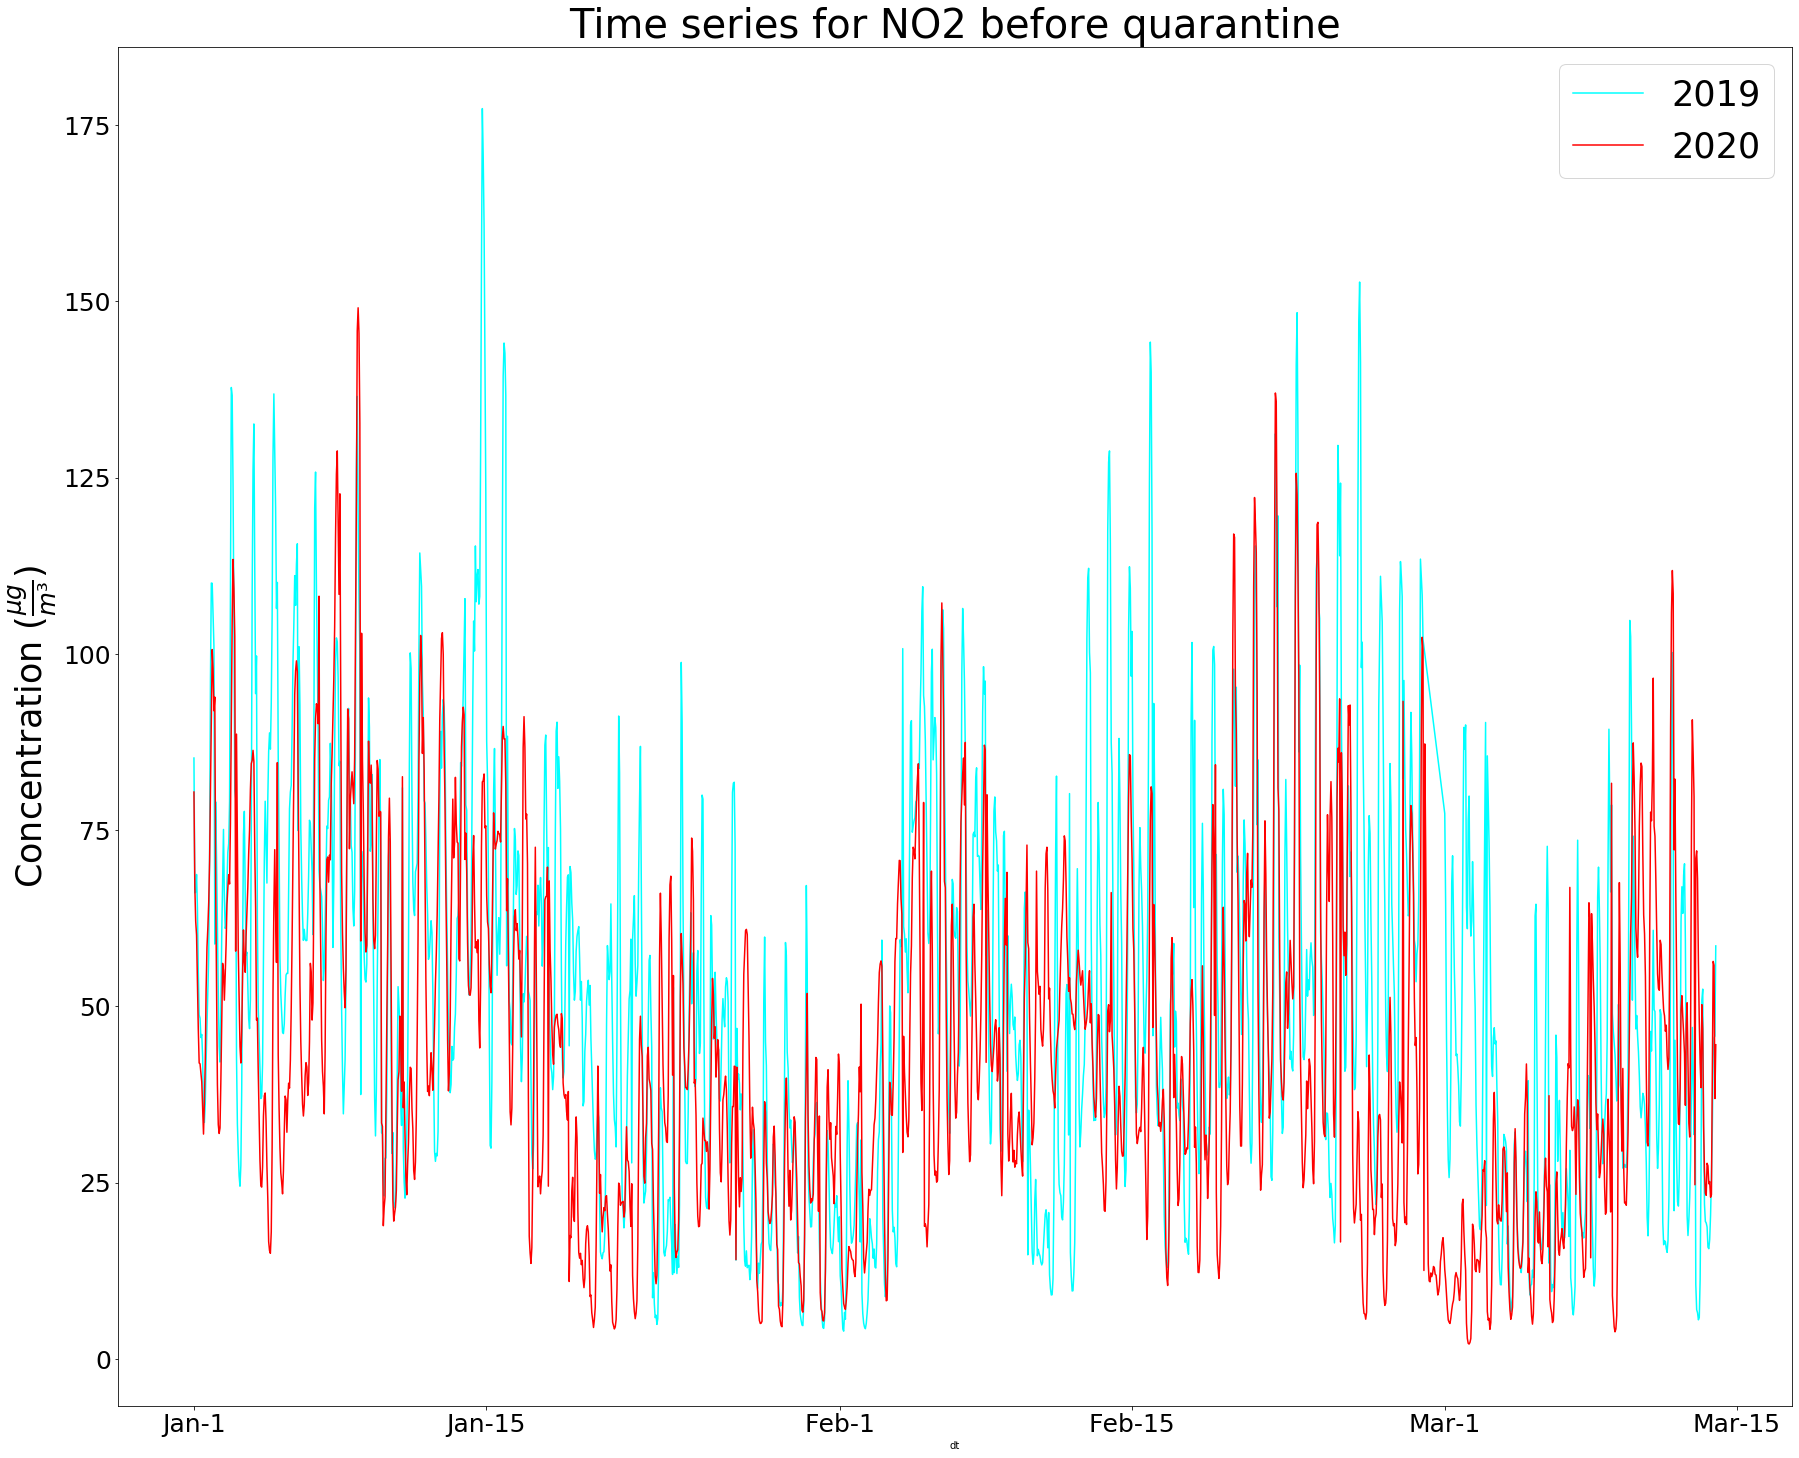

In [9]:
plt.figure(figsize=(30,25))
sns.lineplot(df_bf19.index, df_bf19['concentracion'], label='2019', color='cyan')
sns.lineplot(df_bf20.index, df_bf20['concentracion'], label='2020', color='red')
plt.ylabel(r'Concentration $(\frac{\mu g}{m³})$', fontsize=35)
plt.xticks(ticks=tick_pos, labels=tick_labels, fontsize=25)
plt.yticks(fontsize=25)
plt.title('Time series for ' + pollutant + ' before quarantine', fontsize=40)
plt.legend(fontsize=35);

In [10]:
df_bf19['SMA'] = df_bf19.loc[:,'concentracion'].rolling(window = 24,
                                                min_periods = 1).mean()
df_bf20['SMA'] = df_bf20.loc[:,'concentracion'].rolling(window = 24,
                                                min_periods = 1).mean()

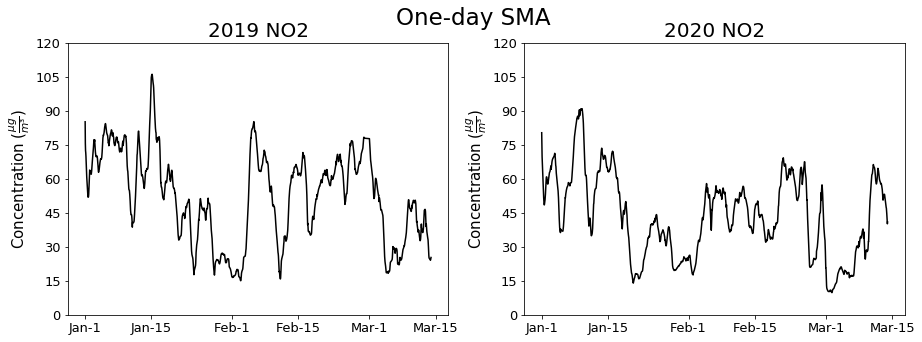

In [11]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
fig.suptitle('One-day SMA', fontsize=23)

ax[0].plot(df_bf19.index, df_bf19['SMA'], color='black')
ax[0].set_title('2019 ' + pollutant, fontsize=20)

ax[1].plot(df_bf20.index, df_bf20['SMA'], color='black')
ax[1].set_title('2020 ' + pollutant, fontsize=20)

for i in range(2):
    ax[i].set_xticks(tick_pos)
    ax[i].set_xticklabels(tick_labels, fontsize=13)
    ax[i].set_yticks(list(range(0,130,15)))
    ax[i].set_yticklabels(list(range(0,130,15)), fontsize=13)
    ax[i].set_ylabel(r'Concentration $(\frac{\mu g}{m³})$', fontsize=15)

The behavior appears to be quite similar, both in raw plots and in trend.

**Trend and seasonality**

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [22]:
res19 = seasonal_decompose(df_bf19['concentracion'].values, freq=24) #Raises an exception if called any other way
#due to missing data. Having done this requires transforming the result object's attributes from np arrays into
#dataframes in order to plot them.
res19.observed = pd.DataFrame(data=res19.observed, index=df_bf19.index)
res19.trend = pd.DataFrame(data=res19.trend, index=df_bf19.index)
res19.seasonal = pd.DataFrame(data=res19.seasonal, index=df_bf19.index)
res19.resid = pd.DataFrame(data=res19.resid, index=df_bf19.index)
res20 = seasonal_decompose(df_bf20['concentracion'])

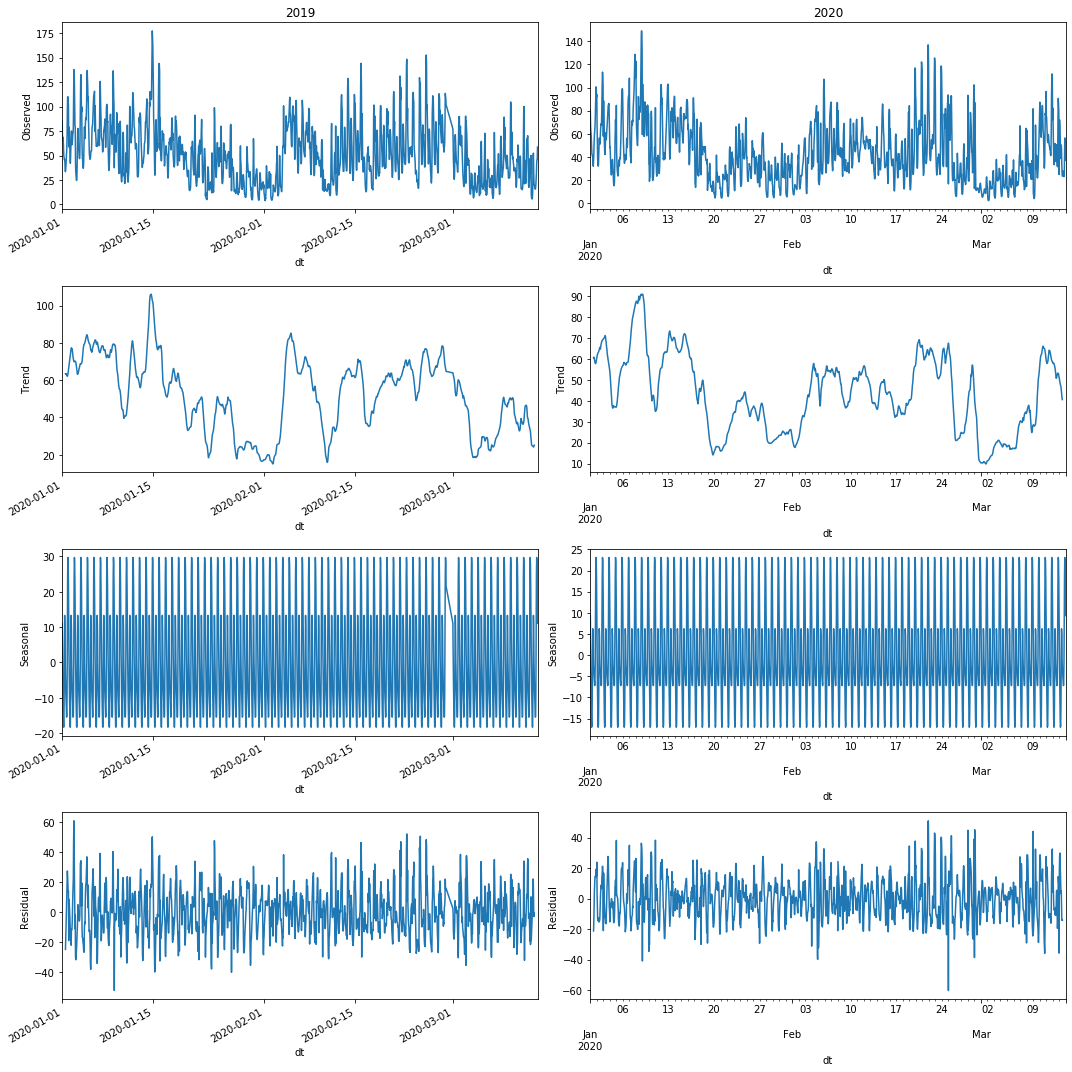

In [23]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize = (15,15))
axes[:,0] = seasonal_plot(res19, axes[:,0], '2019')
axes[:,1] = seasonal_plot(res20, axes[:,1], '2020')
plt.tight_layout()
plt.show()

The behavior of all curves is similar but in 2020 the ranges in which the data vary are smaller.

## Summary statistics and histograms

In [12]:
summ_stats_compare(df_bf19['concentracion'], df_bf20['concentracion'], '2019',
                  '2020')

,2019,2020
count,1729.00,1753.00
mean,51.82,43.40
std,29.41,25.29
min,3.91,2.09
25%,29.48,24.78
50%,48.48,38.65
75%,69.26,58.61
max,177.35,149.09
skew,0.75,0.82
kurtosis,0.42,0.55


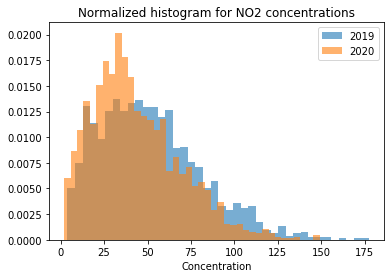

In [13]:
plt.hist(df_bf19['concentracion'].values, bins=40, density=True, 
         label='2019', alpha=0.6)
plt.hist(df_bf20['concentracion'].values, bins=40, density=True,
         label='2020', alpha=0.6)
plt.xlabel('Concentration')
plt.title('Normalized histogram for %s concentrations'%(pollutant))
plt.legend();

The behavior of the two periods is similar, with 2019 spreading out over some higher values. 

## Mean and median comparison

In [14]:
stats_mo_19 = df_bf19.groupby(df_bf19.index.month)['concentracion'].describe()
stats_mo_20 = df_bf20.groupby(df_bf20.index.month)['concentracion'].describe()

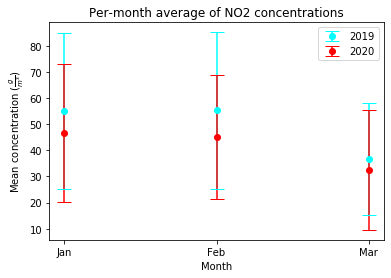

In [15]:
plt.errorbar(stats_mo_19.index, stats_mo_19['mean'], yerr=stats_mo_19['std'], 
             fmt = 'o', label='2019', color='cyan', capsize=7)
plt.errorbar(stats_mo_20.index, stats_mo_20['mean'], yerr=stats_mo_20['std'], 
             fmt = 'o', label='2020', color='red', capsize=7)
plt.title('Per-month average of %s concentrations'%(pollutant))
plt.xlabel('Month')
plt.ylabel(r'Mean concentration $(\frac{g}{m³})$')
plt.xticks(ticks=list(range(1,4)), labels=['Jan','Feb','Mar'])
plt.legend(fontsize=10);

In [16]:
stats_mo_19['mean'] - stats_mo_20['mean']

dt
1     8.607708
2    10.231746
3     4.209518
Name: mean, dtype: float64

In [17]:
#For the boxplot it's necessary to have a column with the months
df_bf19['mes'] = df_bf19.index.month
df_bf20['mes'] = df_bf20.index.month

#Defining label column
month_map = {1:'Jan', 2:'Feb', 3:'Mar',4:'Apr'}
df_bf19['mes_nombre'] = df_bf19['mes'].apply(lambda x: month_map[x])
df_bf20['mes_nombre'] = df_bf20['mes'].apply(lambda x: month_map[x])

In [18]:
df_bf19['year'] = 2019
df_bf20['year'] = 2020
df_both = pd.concat([df_bf19, df_bf20])

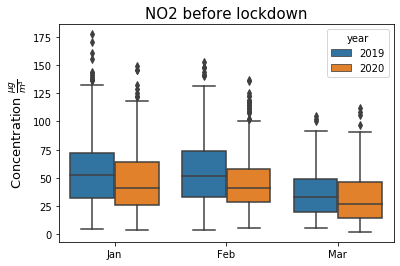

In [19]:
sns.boxplot(x='mes_nombre', y='concentracion', data=df_both, hue='year')
plt.title('%s before lockdown'%(pollutant), fontsize=15)
plt.ylabel(r'Concentration $\frac{\mu g}{m³}$', fontsize=13)
plt.xlabel('');

It's important to remember that in March only days 1-14 are considered, and that there are some missing values in 2019.

In all three months, the median in 2020 is slightly lower than in 2019, but both medians can be found within the IQR of the other year.

## Statistical test for difference in means

A statistical test will be conducted to check if the overall mean is different between both to a statistically significant level. First, I'll check the variances to see if they can be considered equal.

## TO DO: Statistical test for variance 

In [20]:
stats19 = df_bf19['concentracion'].describe()
stats20 = df_bf20['concentracion'].describe()

In [21]:
np.abs(stats19['std'] - stats20['std'])

4.11312673021245

No, they aren't equal, so a Welch t-test will be applied to the difference of the means. First I have to see if the distributions are normal.

In [22]:
df_bf19['conc_norm'] = (df_bf19['concentracion'] - df_bf19['concentracion'].mean())/df_bf19['concentracion'].std()

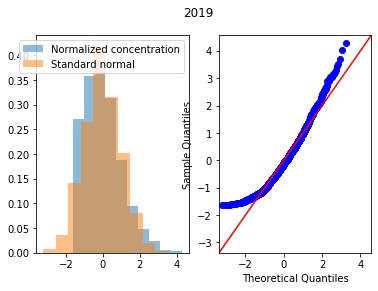

In [23]:
fig, ax = plt.subplots(1,2)
ax[0].hist(df_bf19['conc_norm'].values, density=True, 
           alpha=0.5, label='Normalized concentration')
ax[0].hist(np.random.randn(len(df_bf19)), density=True,
           alpha=0.5, label='Standard normal')
ax[0].legend()
sm.qqplot(df_bf19['conc_norm'], line='45', ax=ax[1])
fig.suptitle('2019');

In [24]:
df_bf20['conc_norm'] = (df_bf20['concentracion'] - df_bf20['concentracion'].mean())/df_bf20['concentracion'].std()

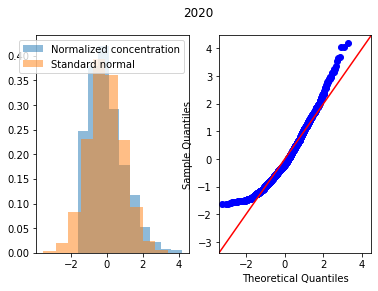

In [25]:
fig, ax = plt.subplots(1,2)
ax[0].hist(df_bf20['conc_norm'].values, density=True, 
           alpha=0.5, label='Normalized concentration')
ax[0].hist(np.random.randn(len(df_bf20)), density=True,
           alpha=0.5, label='Standard normal')
ax[0].legend()
sm.qqplot(df_bf20['conc_norm'], line='45', ax=ax[1])
fig.suptitle('2020');

They're normal enough. The Welch's t-test.

In [26]:
from scipy import stats

In [27]:
stats.shapiro(df_bf19['conc_norm'])

(0.9598610997200012, 1.8956895532312673e-21)

In [28]:
stats.shapiro(df_bf20['conc_norm'])

(0.954194962978363, 5.1418584891029726e-23)

In [29]:
stats.ttest_ind(df_bf19['concentracion'].values, df_bf20['concentracion'].values)

Ttest_indResult(statistic=9.063082840305363, pvalue=2.0675238748322681e-19)

In [30]:
print('The difference in overall mean is:', round(stats19['mean'] - stats20['mean'], 2))

The difference in overall mean is: 8.42


To a statistically significant level (p < 0.05), the two means are unequal. However, because they fall into each other's uncertainty intervals, they can be said to be "close enough" to each other. 

## Autocorrelation and seasonality

In [31]:
#Since 2019 is missing some data, to run a describe on both 
#side-to-side I'll eliminate the missing rows on 2020
temp19 = df_bf19.copy()
temp20 = df_bf20.copy()
to_drop = []
for i in temp20.index:
    if i not in temp19.index:
            to_drop.append(i)
temp20.drop(index=to_drop, inplace=True)

In [32]:
autocorr19 = [temp19['concentracion'].autocorr(tau) for tau in range(len(temp19))]
autocorr20 = [temp20['concentracion'].autocorr(tau) for tau in range(len(temp20))]

In [33]:
df_autocorr = pd.DataFrame({19:autocorr19, 20:autocorr20})
df_autocorr.describe()

,19,20
count,1728.000000,1728.000000
mean,0.022102,0.015260
std,0.220287,0.205431
min,-1.000000,-1.000000
25%,-0.126224,-0.125143
50%,0.015959,0.010096
75%,0.167582,0.139661
max,1.000000,1.000000


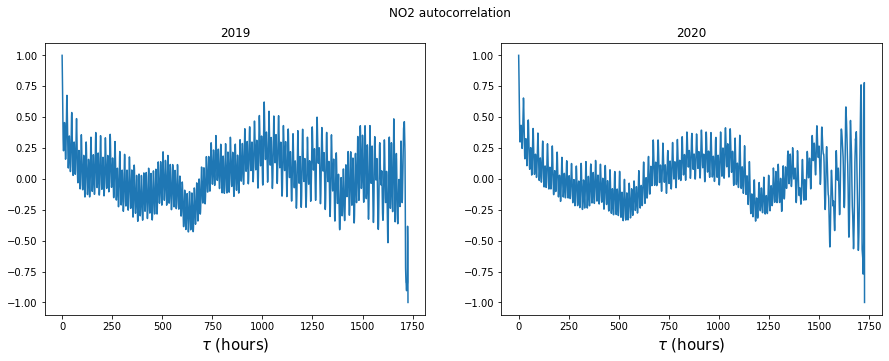

In [34]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
fig.suptitle(pollutant + ' autocorrelation')

ax[0].plot(range(len(autocorr19)), autocorr19)
ax[0].set_title('2019')

ax[1].plot(range(len(autocorr20)), autocorr20)
ax[1].set_title('2020')

for i in range(2):
    ax[i].set_xlabel(r'$\tau$ (hours)', fontsize=15)

#plt.ylabel(r'ACF($\tau$)', fontsize=15)

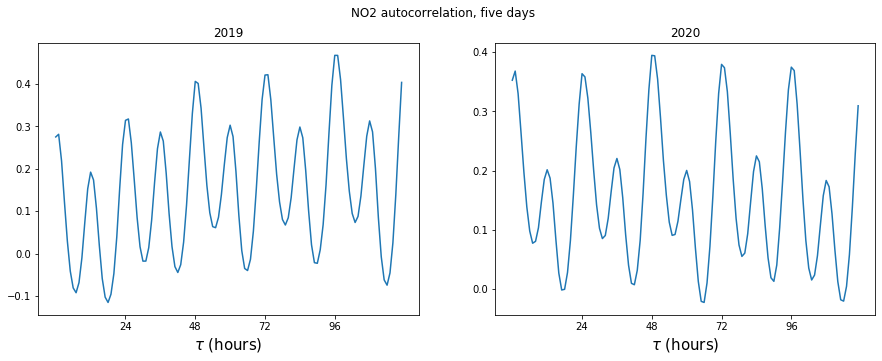

In [35]:
five_days = 24*5
half_point = len(autocorr19)//2
x19 = range(len(autocorr19[half_point:half_point+five_days])) #x coords for 2019
y19 = autocorr19[half_point:half_point+five_days]
x20 = range(len(autocorr20[half_point:half_point+five_days])) #x coords for 2020
y20 = autocorr20[half_point:half_point+five_days]

fig, ax = plt.subplots(1,2, figsize = (15, 5))
fig.suptitle(pollutant + ' autocorrelation, five days')

ax[0].plot(x19, y19)
ax[0].set_title('2019')

ax[1].plot(x20, y20)
ax[1].set_title('2020')

for i in range(2):
    ax[i].set_xlabel(r'$\tau$ (hours)', fontsize=15)
    ax[i].set_xticks(list(range(24, 120, 24)))

Here, the autocorrelation behaves similarly between the two year, with closer values in the summary statistics than in the period after the lockdown.

## Poincaré Diagram

In [36]:
#Calculating the correlation coefficient between x_n and x_{n+1}
df_bf19['concentracion_shift'] = df_bf19['concentracion'].shift(1)
df_bf19[['concentracion','concentracion_shift']].corr()

,concentracion,concentracion_shift
concentracion,1.000000,0.900152
concentracion_shift,0.900152,1.000000


In [37]:
#Performing a linear regression
model = sm.OLS.from_formula('concentracion_shift ~ concentracion', data = df_bf19)
linear_reg19 = model.fit()
linear_reg19.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     concentracion_shift   R-squared:                       0.810
Model:                             OLS   Adj. R-squared:                  0.810
Method:                  Least Squares   F-statistic:                     7371.
Date:                 Tue, 19 May 2020   Prob (F-statistic):               0.00
Time:                         15:00:26   Log-Likelihood:                -6858.5
No. Observations:                 1728   AIC:                         1.372e+04
Df Residuals:                     1726   BIC:                         1.373e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.1711      0.625      8.278      0.000       3.946       6.396
concentracion     0.9005      0.010     85.857      0.000       0.880       0.921
==============================================================================
Omnibus:                      253.682   Durbin-Watson:                   1.428
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1528.298
Skew:                           0.533   Prob(JB):                         0.00
Kurtosis:                       7.482   Cond. No.                         121.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---

In [38]:
df_bf20['concentracion_shift'] = df_bf20['concentracion'].shift(1)
df_bf20[['concentracion','concentracion_shift']].corr()

,concentracion,concentracion_shift
concentracion,1.000000,0.899711
concentracion_shift,0.899711,1.000000


In [39]:
model = sm.OLS.from_formula('concentracion_shift ~ concentracion', data = df_bf20)
linear_reg20 = model.fit()
linear_reg20.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     concentracion_shift   R-squared:                       0.809
Model:                             OLS   Adj. R-squared:                  0.809
Method:                  Least Squares   F-statistic:                     7435.
Date:                 Tue, 19 May 2020   Prob (F-statistic):               0.00
Time:                         15:00:26   Log-Likelihood:                -6693.5
No. Observations:                 1752   AIC:                         1.339e+04
Df Residuals:                     1750   BIC:                         1.340e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.3472      0.524      8.293      0.000       3.319       5.375
concentracion     0.9003      0.010     86.229      0.000       0.880       0.921
==============================================================================
Omnibus:                      534.377   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8957.719
Skew:                           0.976   Prob(JB):                         0.00
Kurtosis:                      13.904   Cond. No.                         99.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

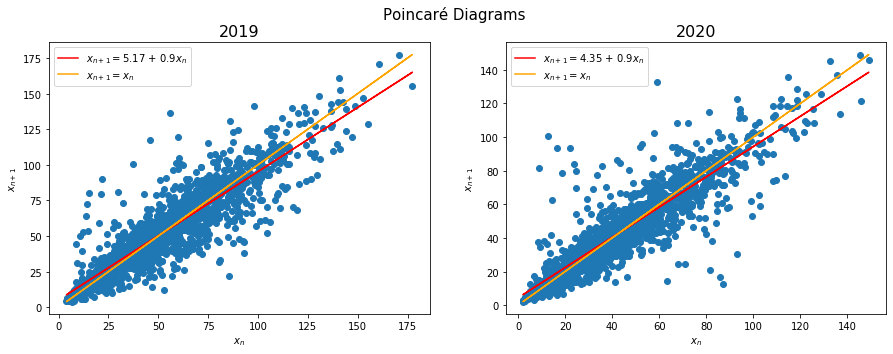

In [40]:
poincare_plot(df_bf19[['concentracion','concentracion_shift']].values,
              df_bf20[['concentracion','concentracion_shift']].values,
             linear_reg19.params, linear_reg20.params,
             '2019', '2020')

The correlation coefficients and slopes are the same for both graphs.

In conclusion, for NO2 there is a very small (though statistically significant) difference in the levels of pollutant concentration in Madrid between the period of quarantine in 2020 and the equivalent period in 2019, whose cause remains to be seen (and I would like to believe is due to noise). The actual behavior of the pollutant, however remained largely the same across all different tests.